<a target="_blank" href="https://colab.research.google.com/github/ajwallacemusic/rag-with-chatgpt-langchain-elasticsearch/blob/main/rag_with_chatgpt_langchain_elasticsearch.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# RAG with ChatGPT, Langchain & Elasticsearch



## Overview
### What is RAG?
RAG (Retrieval Augmented Generation) is a technique for leveraging custom data within LLM applications.
### Why RAG?
RAG is a simple, cost effective way to expand (or narrow) the knowledgebase of an LLM. It allows customization of the LLM's knowledge and context without the labor of fine tuning an LLM model.
### Who is This Guide For?
This guide is for anyone interested in Generative AI, but has limited Machine Learning resources (preventing fine tuning models), wants to explore an efficient method for providing a chatGPT-like experience powered by their own data, or is just curious about Generative AI!
### Guide Format & Requirements
This guide was written as an interactive notebook and assumes that you have basic software engineering skills, including familiarity with python and Jupyter notebooks. The goal is not just to read it, but to interact with it and play with it!

Feel free to open it in [Google Colab]("https://colab.research.google.com/github/ajwallacemusic/rag-with-chatgpt-langchain-elasticsearch/blob/main/rag_with_chatgpt_langchain_elasticsearch.ipynb"), clone the [github repo](https://github.com/ajwallacemusic/rag-with-chatgpt-langchain-elasticsearch) and run locally with Jupyter, run with VS Code, or use any other method for running a Jupyter style notebook.

> Note: Google Colab is the recommended method since it creates a clean virtual environment to install our dependencies. If you're savvy with Jupyter Notebooks, please clone the repo and run your preferred way.

Lastly, you also need an OpenAI account since that is the LLM provider we will use, and some familiarty with Elasticsearch and LangChain would be nice, but not required!

## How to RAG

First we'll setup our dependencies and index data into a VectorStore.

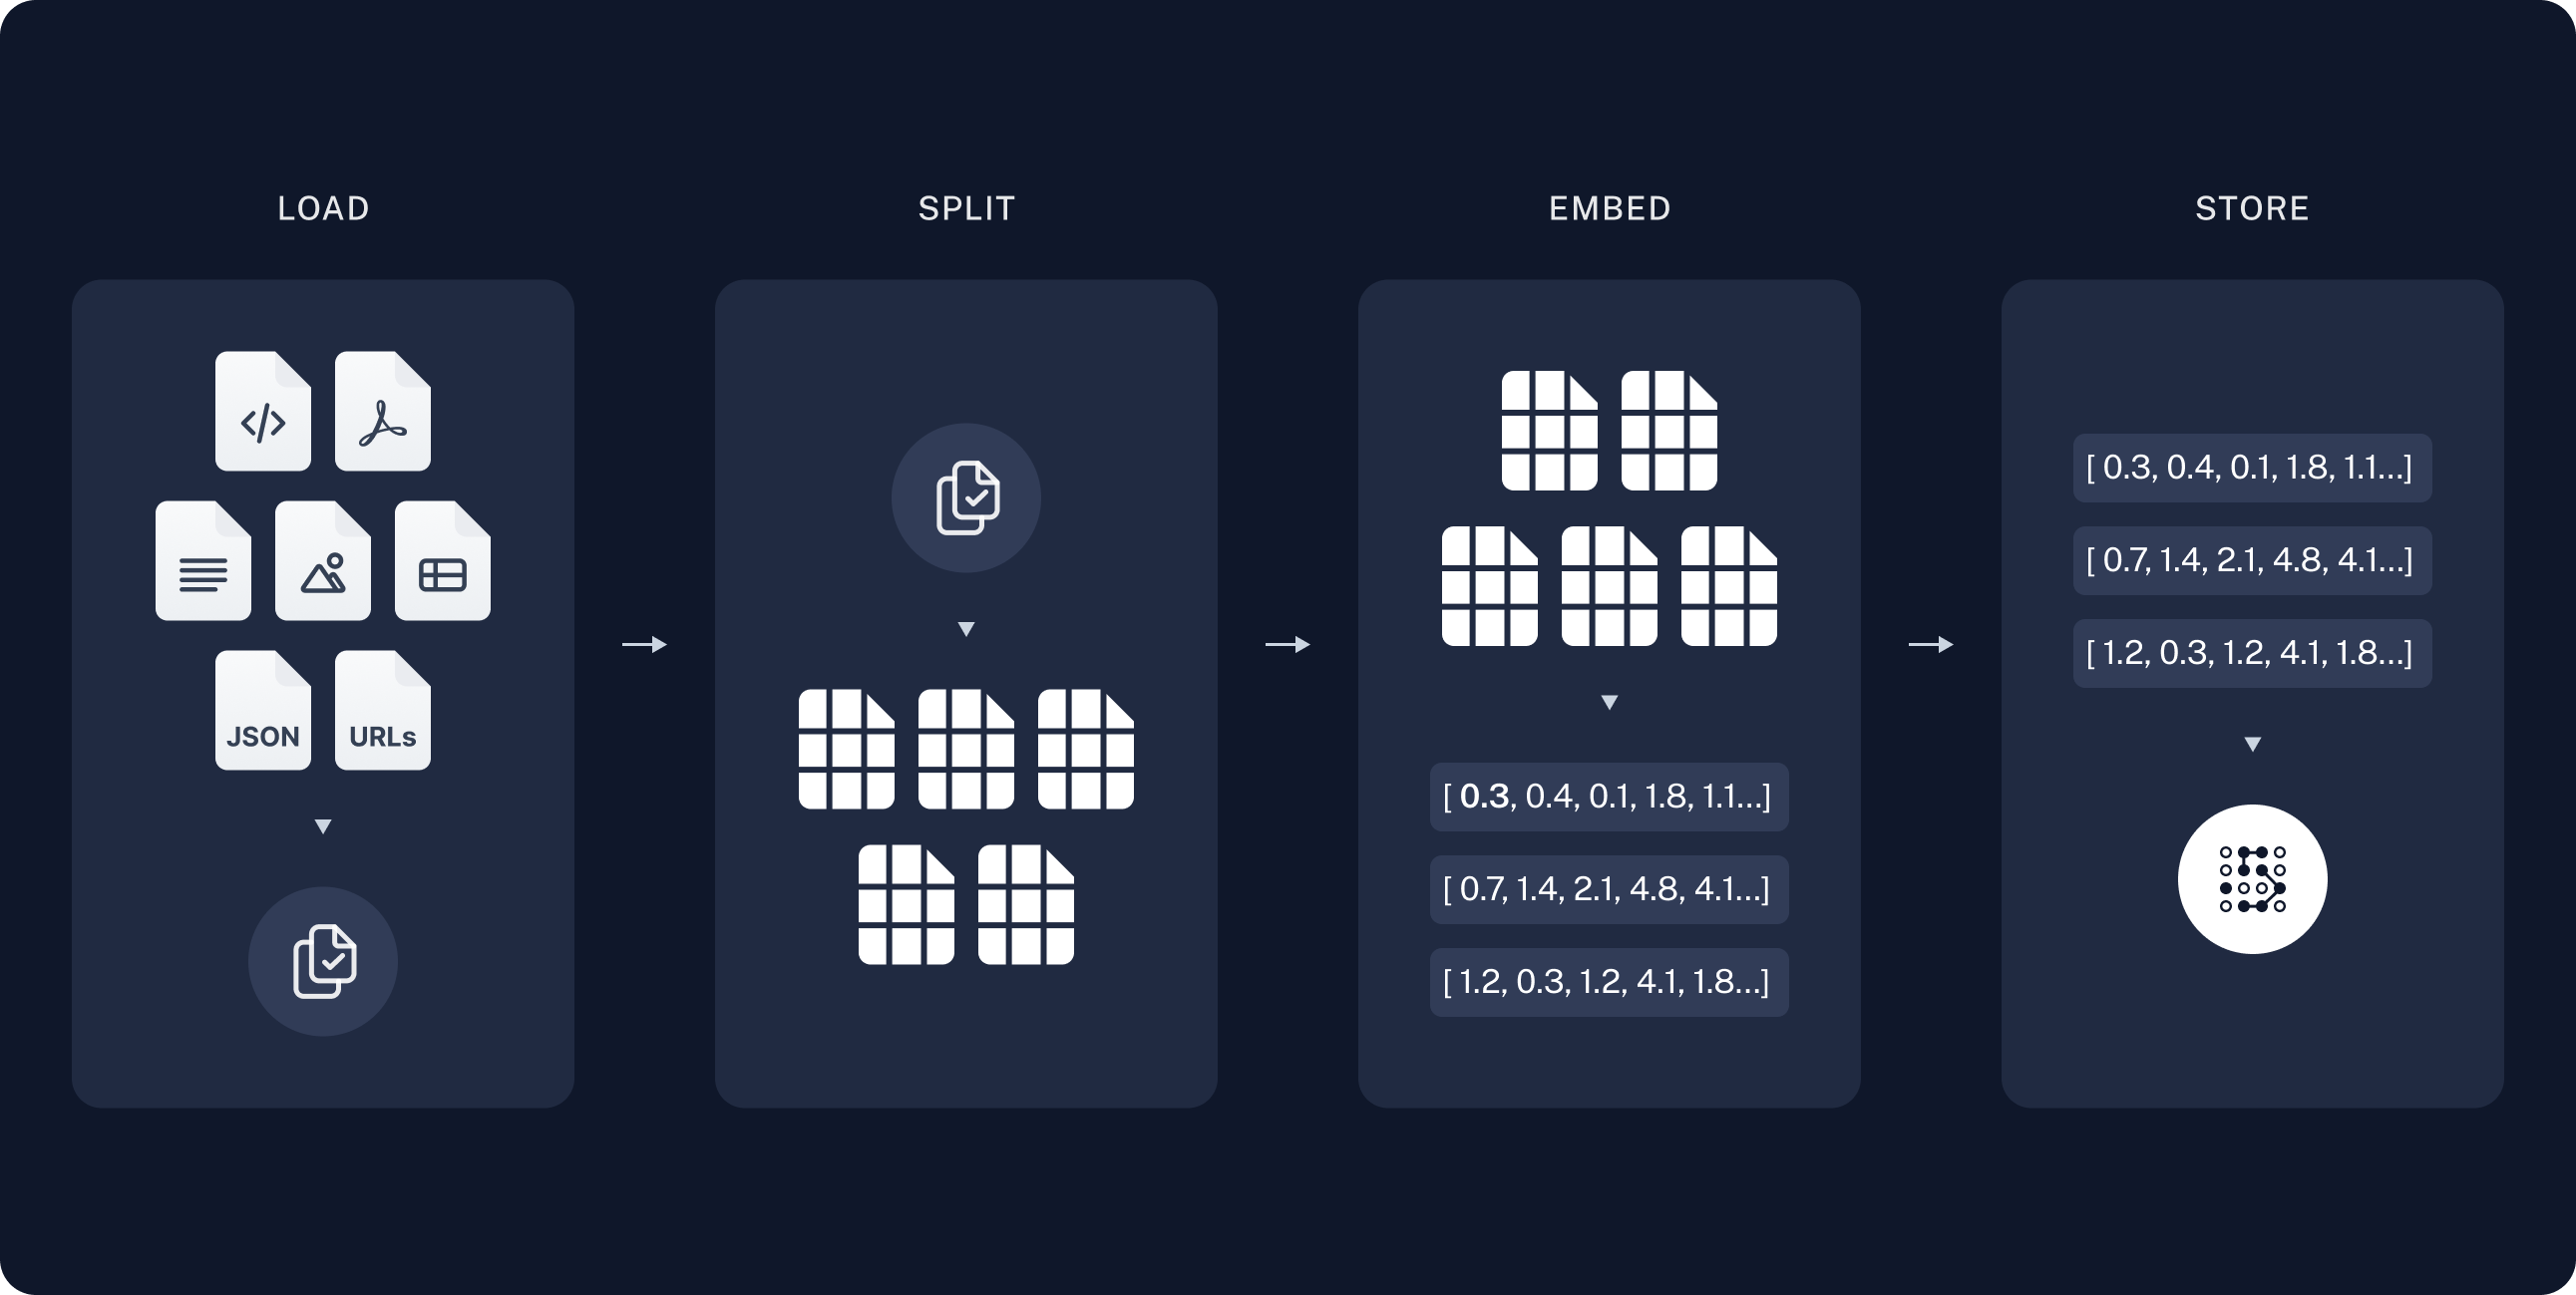

Then we'll test out our SimilaritySearch and execute a RAG chain.

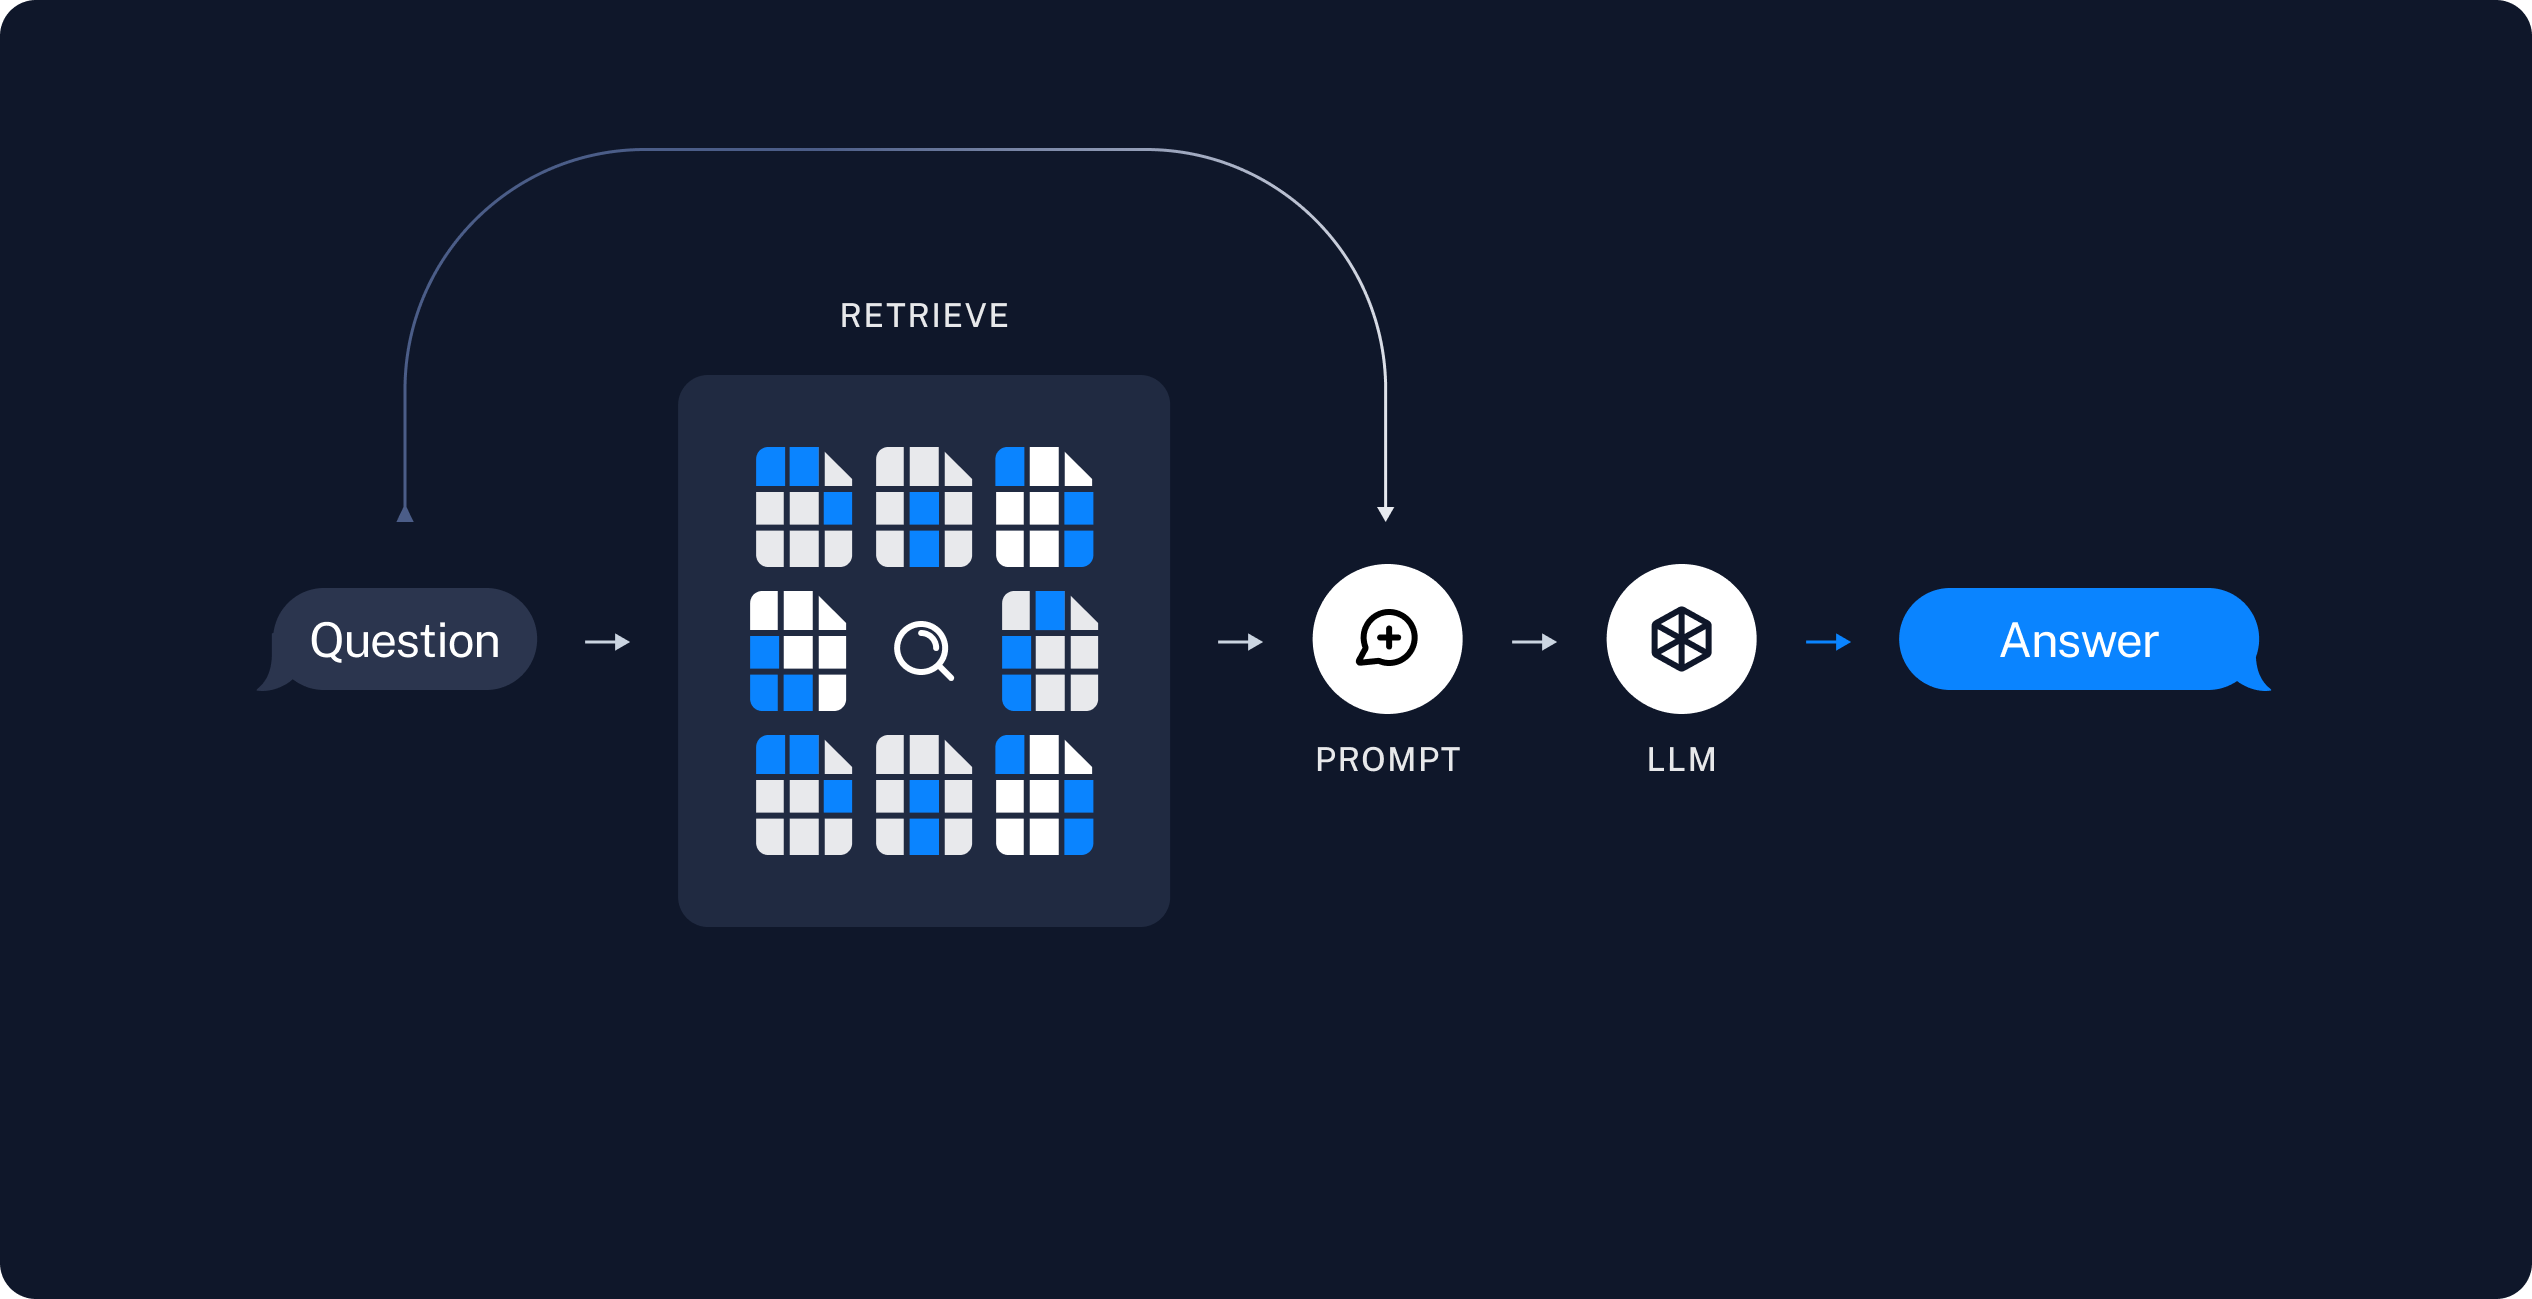

(Images sourced from [LangChain's documentation]("https://python.langchain.com/docs/use_cases/question_answering/#architecture"))

---

## Install Packages & Import Modules

In [ ]:
%%capture

# install packages
!python3 -m pip install -qU elasticsearch==8.11.1 langchain \
sentence_transformers openai pypdf python-dotenv

# import generic modules
from IPython.display import display
from dotenv import load_dotenv
from getpass import getpass
from urllib.request import urlretrieve
import os


## Setup Elasticsearch

There are 3 main options for connecting an Elasticsearch cluster to this notebook:

1. download and run the Elasticsearch binary
2. run a docker container
3. connect to an Elastic Cloud cluster

The method you choose will depend on a couple of factors:

1. where you are running this notebook
2. whether you have an Elastic Cloud account

If you are running this notebook in Google Colab, it is recommended to use the binary installation or Elastic Cloud account since Docker is not supported within Google Colab.

If you are running locally (ie, a Jupyter notebook or VS Code notebook), you can choose any approach.

#### Enum to Track Connection Type

In [ ]:
from enum import Enum

# let's setup a simple enum to help us keep track of our ES connection type
class ESConnection(Enum):
    NONE = 0
    BINARY = 1
    DOCKER = 2
    CLOUD = 3

es_connection = ESConnection.NONE
print(f"es_connection: {es_connection.name}")

### ES binary via .tar Package (Google Colab Only)

In [ ]:
%%capture

# remove any previous elasticsearch installations, download and export es version 8.11.1
!rm -rf elasticsearch*
# !wget -q https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-8.11.1-linux-x86_64.tar.gz
url = "https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-8.11.1-linux-x86_64.tar.gz"
file_name = 'es_download'
urlretrieve(url, file_name)

!tar -xzf es_download
# elasticsearch-8.11.1-linux-x86_64.tar.gz

# set up user to run ES daemon and configure cgroups
!sudo chown -R daemon:daemon elasticsearch-8.11.1/
!umount /sys/fs/cgroup
!apt install cgroup-tools

es_connection=ESConnection.BINARY

Disable security and set elasticsarch.yml parameters

In [ ]:
# Disable security and allow anonymous users
# WARNING: this is for demo purposes only. Always use security and authentication for real world applications
with open('./elasticsearch-8.11.1/config/elasticsearch.yml', 'a') as writefile:
    writefile.write("xpack.security.enabled: false\n")
    writefile.write("xpack.security.authc:\n")
    writefile.write("  " + "anonymous:\n")
    writefile.write("    " + "username: anonymous_user\n")
    writefile.write("    " + "roles: superuser\n")
    writefile.write("    " + "authz_exception: true")

# if you want to verify that the elasticsearch.yml file is written to correctly, uncomment this code block
#with open('./elasticsearch-8.11.1/config/elasticsearch.yml', 'r') as readfile:
#    print(readfile.read())

Start ES Daemon in Background

In [ ]:
%%bash --bg

sudo -H -u daemon elasticsearch-8.11.1/bin/elasticsearch

It takes ES a while to get running, so be sure to wait a few seconds, or just run the manual 30 second sleep command below.

In [ ]:
!sleep 30

#### Check Elasticearch binary
We'll run a few checks to make sure Elasticsearch is up and running, and accessible

In [ ]:
# Check if elasticsearch is running
# There should be 3 daemon elasticsearch processes and 3 root processes in the list when grepping for elasticsearch
!ps -ef | grep elastic

# curl the cluster once with the elastic superuser and default password so that we can do anonymous calls moving forward
# WARNING: do not pass user passwords like this in real life. This. is. a. demo.
!curl -u elastic:password -H 'Content-Type: application/json' -XGET http://localhost:9200/?pretty=true

### Docker (Local Notebook)

Docker doesn't work in Google Colab. But if you're running this notebook locally, you can spin up a docker container to connect to. Checkout Elasticsearch's guide for setting up a [single container](https://www.elastic.co/guide/en/elasticsearch/reference/current/docker.html), or [multi-node cluster with docker-compose](https://www.elastic.co/guide/en/elasticsearch/reference/current/docker.html#docker-compose-file).

The docker-compose approach is nice because you almost never have a single node cluster, and you get kibana with it as well. One big thing to note is that the docker-compose file sets up ssl and security (username/password) by default, which our notebook is not configured to handle, so you'll want to set the security values to false and comment out the ssl stuff. Here's an [example](https://github.com/ajwallacemusic/rag-with-chatgpt-langchain-elasticsearch/blob/main/docker-compose.yml) of what the docker-compose file might look like.

Our [example .env](https://github.com/ajwallacemusic/rag-with-chatgpt-langchain-elasticsearch/blob/main/.env_example) file includes environment variables for the docker-compose file. Assuming the `.env_example` file has been renamed to `.env`, you can run `docker-compose up` in a local terminal, and your notebook should be able to connect.

> NOTE: our notebook assumes url of `http://localhost:9200` when running Elasticsearch on docker.

In [ ]:
# uncomment this block to use Docker connection

#es_connection=ESConnection.DOCKER

### Elastic Cloud

Many organizations may already have an Elastic Cloud cluster to connect to. Or maybe you have a free trial. In either case, we can simply pass in the cloud id and api key to create a client.

Please refer to the [Elasticsearch documentation](https://www.elastic.co/guide/en/cloud/current/ec-api-keys.html) for retreiving this information. We will pass these values in securely when we setup environment variables in our next step.

In [ ]:
# uncomment this block to use Elastic Cloud connection

#es_connection=ESConnection.CLOUD

## Setup Environment Variables

To integrate our RAG app with OpenAI and Elasticsearch, we need to pass some sensitive data, like api keys and passwords. We'll use python's getpass package to input the sensitve info, and store it in a .env file that we can then use in our code.

It's a bit of a roundabout approach, but better than pasting senstive data directly into the code. You can skip to the `load_dotenv()` function if running locally and have your own .env file at the root directory, next to the ipynb file.

In [ ]:
# create .env file
!touch .env

with open('.env', 'a') as envFile:
  # write openai api key
  envFile.write("OPENAI_API_KEY=" + getpass(prompt="enter your openai api key ") + "\n")
  # if running es binary or docker, add the es_url
  if es_connection == ESConnection.BINARY or es_connection == ESConnection.DOCKER:
    envFile.write("ELASTICSEARCH_URL=http://localhost:9200" + "\n")
  # if running es cloud, enter cloud id and api key
  elif es_connection == ESConnection.CLOUD:
    envFile.write("ELASTIC_CLOUD_ID=" + getpass(prompt="enter your ES cloud id ")+ "\n")
    envFile.write("ELASTIC_API_KEY=" + getpass(prompt="enter your ES cloud api key "))

# uncomment this section if you need to double check the .env file
# with open('.env', 'r') as readfile:
#     print(readfile.read())

In [ ]:
# Load variables from .env file
load_dotenv('.env')

# Set local variables
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
ELASTIC_CLOUD_ID = os.getenv("ELASTIC_CLOUD_ID")
ELASTIC_API_KEY = os.getenv("ELASTIC_API_KEY")
ELASTICSEARCH_URL = os.getenv("ELASTICSEARCH_URL")

## Final Elasticsearch Check

Instantiate Elasticsearch python client based on installation type and double check connection.

In [ ]:
from elasticsearch import Elasticsearch

# determine what connection data to pass to the client init
if ELASTICSEARCH_URL:
    elasticsearch_client = Elasticsearch(
        hosts=[ELASTICSEARCH_URL],
    )
elif ELASTIC_CLOUD_ID:
    elasticsearch_client = Elasticsearch(
        cloud_id=ELASTIC_CLOUD_ID, api_key=ELASTIC_API_KEY
    )
else:
    raise ValueError(
        "Please provide either ELASTICSEARCH_URL or ELASTIC_CLOUD_ID and ELASTIC_API_KEY"
    )

print(elasticsearch_client.info())

## Load Data

Our dataset is a pdf of the United States Code Title 3 - The President, available from [The Office of Law Revision Counsel website](https://uscode.house.gov/download/download.shtml). We use langchain's [PyPDFLoader](https://python.langchain.com/docs/modules/data_connection/document_loaders/pdf#using-pypdf) to load the pdf and split into pages.

Langchain provides many different types of [document loaders](https://python.langchain.com/docs/modules/data_connection/document_loaders/) for a myriad of data sources. Additionally, sometimes the documents need to be parsed and split into smaller chunks for ingestion. This can be done using [document transformers](https://python.langchain.com/docs/modules/data_connection/document_transformers/).

At their core, document loaders translate source data into langchain [Document](https://python.langchain.com/docs/modules/data_connection/document_loaders/) objects, which consist of `page_content`, and optional `metadata`.

#### Get the PDF and Split into Pages

In [ ]:
from langchain.document_loaders import PyPDFLoader

# get the us code pdf on the president and unzip it
from urllib.request import urlretrieve
url = "https://uscode.house.gov/download/releasepoints/us/pl/118/22u1/pdf_usc03@118-22u1.zip"
file_name = "president.pdf.zip"
urlretrieve(url, file_name)
!unzip president.pdf.zip

# now load the pdf as text and break into pages
loader = PyPDFLoader("usc03@118-22.pdf")
pages = loader.load_and_split()

Next, we instantiate a langchain VectorStore of the [ElasticsearchStore](https://python.langchain.com/docs/integrations/vectorstores/elasticsearch) type.



#### Instantiate ElasticsearchStore

In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import ElasticsearchStore

# set our embedding model
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# instantiate vectorstore from documents
esVectorStore = ElasticsearchStore.from_documents(
    pages,
    es_connection=elasticsearch_client,
    index_name="the-president",
    embedding=embeddings
)

# verify the ElasticsearchStore was created
esVectorStore

We're using the `from_documents()` function, which creates a new index and ingests our documents automatically. It accepts our list of documents (pages), embedding function (in our case, an SBERT sentence transformer available from Hugging Face), and Elasticsearch client and index. You can also pass in Elasticsearch url/credentials if you haven't already instantiated an Elasticsearch client.

Our new index will consist of documents with text and embedding fields. If we had added metadata to our documents when loading our pdf, it would also index this information. ([Metadata](https://python.langchain.com/docs/integrations/vectorstores/elasticsearch#filtering-metadata) can be information like the document name, page number, date, etc. and is useful for filtering or aggregating on our searches.)

Alternatively, if you have an existing Elasticsearch index you want to use, or want to manage your index separately from the built in langchain `from_documents` function, you can instantiate the Elasticsearchstore by iteslef:
```python
esVectorStore = ElasticsearchStore(
            es_url="http://localhost:9200",
            index_name="test_index",
            embedding=embedding
        )
```

> Though we're using an SBERT sentence transformer, additional embedding models are available. Langchain integrates with many different  [embedding providers](https://python.langchain.com/docs/integrations/text_embedding), including OpenAI, SpaCy, Elasticsearch and more.

## Test Similarity Search

Next, we test our `similarity_search` function to ensure we pass appropriate context to our langchain prompt.

#### Helper Function

In [ ]:
# helper function
def showResults(results):
  print("Total results: ", len(results))
  for i in range(len(results)):
    print(results[i])

`showResults()` is a just a helper function to help display our results later.

#### Similarty Search

In [ ]:
query = "who succeeds the president"
result = esVectorStore.similarity_search(query=query)

showResults(result)

We use the default `similarity_search()` function from langchain. By default it will use [ApproxRetrievalStrategy](https://python.langchain.com/docs/integrations/vectorstores/elasticsearch#approxretrievalstrategy). This uses the Elasticsearch [Approximate kNN ](https://www.elastic.co/guide/en/elasticsearch/reference/current/knn-search.html#approximate-knn) search using the embedding model we specified in the VectorStore, and the HNSW algorithm and cosine distance.

There are other retieval strategies, distance strategies, and model options to choose from when setting up the ElasticsearchStore. The langchain documentation has helpful examples including [hybrid search](https://python.langchain.com/docs/integrations/vectorstores/elasticsearch#example-approx-with-hybrid), [using custom Elasticsearch embedding models](https://python.langchain.com/docs/integrations/vectorstores/elasticsearch#example-approx-with-embedding-model-in-elasticsearch), [using Sparse Vectors with ELSER ](https://python.langchain.com/docs/integrations/vectorstores/elasticsearch#sparsevectorretrievalstrategy-elser), and [using a completely custom Elasticsearch query](https://python.langchain.com/docs/integrations/vectorstores/elasticsearch#customise-the-query) (in the example, they replace the similarity query with a basic BM25 match query.)

For more information about the ElasticsearchStore class, checkout the [api documentation ](https://api.python.langchain.com/en/latest/vectorstores/langchain_community.vectorstores.elasticsearch.ElasticsearchStore.html?highlight=elasticsearchstore#). For an even further in-depth look at what goes on under the hood, reference the [Elsticsearch vector store github repo](https://github.com/langchain-ai/langchain/blob/master/libs/community/langchain_community/vectorstores/elasticsearch.py).

## Executing RAG

Finally, we setup and execute our RAG chain.

When prompted below, try asking questions about the President:
- What are the president's duties?
- How often is the president elected?
- Who succeeds the president?

In [ ]:
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough

retriever = esVectorStore.as_retriever(search_kwargs={"k": 3})

template = """Answer the question with the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | ChatOpenAI(openai_api_key=OPENAI_API_KEY)
    | StrOutputParser()
)

q = input("Question: ") or "What is the electoral college?"
print("\n")
reply = chain.invoke(q)
display("Answer: " + reply)


### Breakdown the Chain
It's not a ton of code, but there's a lot going on here, so let's break it down.

#### Retriever
```python
retriever = esVectorStore.as_retriever(search_kwargs={"k": 3})
```
First we set up something called a [Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/). This is a LangChain component to return documents to pass as context to our prompt. It doesn't have to be based on a VectorStore, but in our case, that's exactly what it is -- our ElasticsearchStore is what we use to search and retrieve relevant documents.

You don't have to use a retriever. LangChain's prompt template supports something called [RunnableLambda's](https://python.langchain.com/docs/expression_language/how_to/functions), which are just custom functions you can pass to the prompt.

#### Prompt
```python
template = """Answer the question with the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)
```
This is of course the prompt we will pass to the LLM. We set up a template which sets up our `context` and passes through the inputted `question`.

#### Chain
```python
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | ChatOpenAI(openai_api_key=OPENAI_API_KEY)
    | StrOutputParser()
)
```
The chain is the core of what LangChain does (hence the name, right?). They provide a simple syntax language (LangChain Expression Language aka LCEL) that uses pipes akin to unix pipes. We set our variables here to pass `context` and `question` to our prompt. We specify the LLM model to use (ChatOpenAI), and lastly we specify an output parser to make sure our output is a string.

#### Invoke
```python
q = input("Question: ") or "What is the electoral college?"
print("\n")
reply = chain.invoke(q)
display("Answer: " + reply)
```
The last step here is to prompt for a user question, which we then pass to the `chain.invoke()` function. This of course, runs the chain which triggers an Elasticsearch query with the question as input, and then returns the result as context in our LLM prompt. The LLM prompt also uses the original question.

The result is that our question is answerd by the LLM based on the data retreived by Elasticsearch.

---

## Go Deeper

This guide has walked through the basic steps of setting up RAG by using LangChain to load data from a pdf, create a VectorStore in Elsticsearch, query Elasticsearch for relevant data, and pass that data to ChatGPT as context in a prompt.

Along the way we mentioned different ways to customize this application including using an existing Elasticsearch index, customizing the Elasticsearch query, using custom language models for embedding, and that's just the start!

If you want to learn more, the best way is to experiment. Maybe try loading different data type (you can retrieve the same US Code data as html for example), or a different data source ([gutenberg.org](https://www.gutenberg.org/) is a free online source where you can access public domain books, for example.)

Play with different Elasticsearch retrieval and distance strategies. How does BM25 compare to semantic similarity and hybrid search?

Maybe try a [custom LLM](https://python.langchain.com/docs/modules/model_io/llms/custom_llm), like [Dolly](https://www.databricks.com/blog/2023/04/12/dolly-first-open-commercially-viable-instruction-tuned-llm), or [Llama](https://ai.meta.com/blog/large-language-model-llama-meta-ai/).

Here's a crazy suggesion -- try a different Vector Store. [Opensearch](https://python.langchain.com/docs/integrations/vectorstores/opensearch) is a great Lucene-based alternative to Elasticsearch, but you could even try a different open-source vector database, like Chroma.

## Closing
Of course, reach out to us at [Gigasearch](https://www.gigasearch.co/#contact_us) if you have any questions. We'd be happy to talk about RAG, how you could implement generative AI in your business, or any general Elasticsearch/Opensearch questions you may have.